# Setup

In [1]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import time
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
assert torch.cuda.is_available()

In [3]:
import sys
sys.path.append('../')
from data import LibriSpeechDataset, label_to_sex
from models import DilatedNet, ConvNet

In [4]:
n_seconds = 3
base_sampling_rate = 16000
downsampling = 4
batchsize = 8

# Get data

In [5]:
# trainset = LibriSpeechDataset('train-clean-100',base_sampling_rate*n_seconds)
trainset = LibriSpeechDataset(['train-clean-100','train-clean-360'],base_sampling_rate*n_seconds)
testset = LibriSpeechDataset('dev-clean',base_sampling_rate*n_seconds,stochastic=False)

Indexing data...
Finished indexing data. 129652 usable files found.
Indexing data...
Finished indexing data. 2303 usable files found.


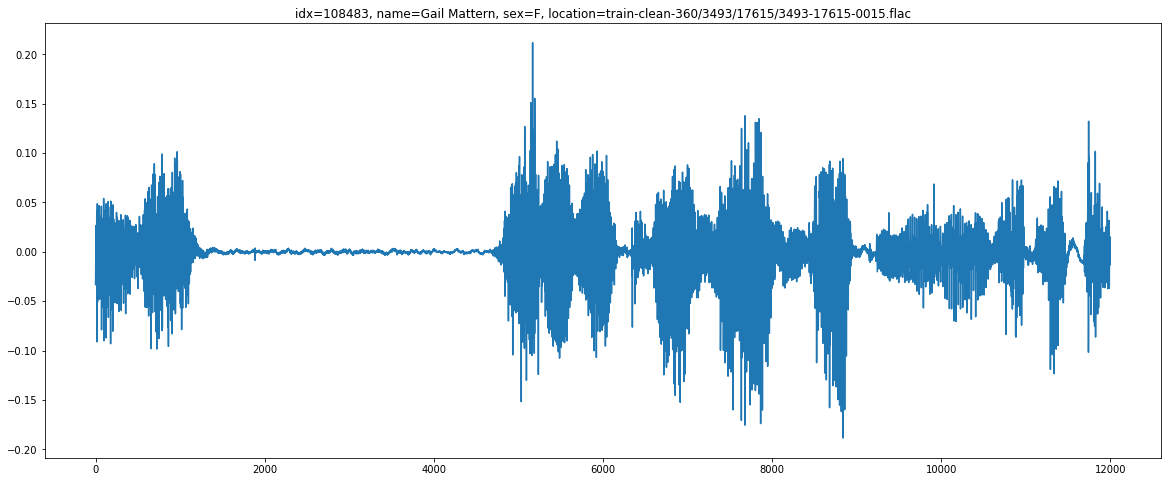

In [6]:
idx = np.random.randint(0,len(trainset))
instance, label = trainset[idx]

plt.figure(figsize=(20,8))
title_string = 'idx={}, name={}, sex={}, location={}'.format(
    idx,
    trainset.datasetid_to_name[idx],
    label_to_sex[label],
    '/'.join(trainset.datasetid_to_filepath[idx].split('/')[-4:])
)
plt.title(title_string)
plt.plot(instance[::downsampling])
plt.show()

In [7]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize,num_workers=4,shuffle=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=batchsize,num_workers=4,shuffle=True)

### Define model

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [9]:
# model = DilatedNet(128, 7, 1)
model = ConvNet(64, 6)
model.double()
model.cuda()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

In [10]:
count_parameters(model)

87681

In [11]:
def evaluate(dataloader=testloader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            timeseries, labels = data
            if timeseries.shape[0] != batchsize:
                # incomplete batch
                continue
            timeseries = normalise(timeseries)
            timeseries = timeseries.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
            predicted = model(timeseries)
            total += labels.size(0)
            correct += ((predicted > 0.5)[:,0] == labels.cuda().byte()).cpu().sum().numpy()
            
    return correct*1.0/total

In [12]:
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [13]:
torch.backends.cudnn.benchmark = True

In [14]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=32)

In [15]:
# def normalise(instance,mean=0,rms=0.038021):
#     # default is mean RMS of first 3 seconds of every dev sample
#     instance = instance - instance.mean()
#     instance_rms = np.sqrt(np.square(instance)).mean()
#     return instance*(rms/instance_rms)

def normalise(batch,mean=0,rms=0.038021):
    m = batch.mean(dim=1)
    transform = batch-m.repeat([inputs.shape[1],1]).transpose(dim0=1,dim1=0)
    transform = transform*rms/torch.abs(transform).mean(dim=1).repeat([inputs.shape[1],1]).transpose(dim0=1,dim1=0)
    return transform

In [16]:
print_every = 500  # batches
best_accuracy = 0
t0 = time.time()
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    running_correct_samples = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        if inputs.shape[0] != batchsize:
            # incomplete batch
            continue
        
        # Normalise the volume to a fixed root mean square value as some speakers are much quieter than others
        inputs = normalise(inputs)
        inputs = inputs.reshape((batchsize,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
        
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.reshape((batchsize,1)).cuda().double())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_correct_samples += torch.eq((outputs[:,0] > 0.5).cpu(), labels.byte()).numpy().sum()
        if i % print_every == print_every - 1:    # print every 'print_every' mini-batches
            val_acc = evaluate()
            
            # return model to training mode
            model.train()
            
            print('[%d, %5d, %.1f] loss: %.3f acc: %.3f val_acc: %.3f' %
                  (epoch + 1, i + 1, time.time()-t0,
                   running_loss / print_every, 
                   running_correct_samples*1. / (print_every*batchsize), 
                   val_acc))
            running_loss = 0.0
            running_correct_samples = 0
            
            # Save new model if its the best
            if val_acc > best_accuracy:
                print 'Saving new best model'
                torch.save(model.state_dict(),'../models/extradata2.torch')
                best_accuracy = val_acc
                
            # Check for plateau
            scheduler.step(val_acc)

print('Finished Training')

[1,   500, 30.0] loss: 0.349 acc: 0.851 val_acc: 0.958
Saving new best model
[1,  1000, 59.6] loss: 0.226 acc: 0.919 val_acc: 0.958
[1,  1500, 88.9] loss: 0.202 acc: 0.926 val_acc: 0.973
Saving new best model
[1,  2000, 118.2] loss: 0.174 acc: 0.942 val_acc: 0.963
[1,  2500, 147.6] loss: 0.151 acc: 0.943 val_acc: 0.978
Saving new best model
[1,  3000, 177.1] loss: 0.147 acc: 0.947 val_acc: 0.970
[1,  3500, 206.4] loss: 0.150 acc: 0.945 val_acc: 0.970
[1,  4000, 235.8] loss: 0.141 acc: 0.949 val_acc: 0.947
[1,  4500, 265.2] loss: 0.160 acc: 0.940 val_acc: 0.975
[1,  5000, 295.1] loss: 0.126 acc: 0.955 val_acc: 0.975
[1,  5500, 324.5] loss: 0.117 acc: 0.955 val_acc: 0.976
[1,  6000, 354.0] loss: 0.120 acc: 0.959 val_acc: 0.980
Saving new best model
[1,  6500, 383.5] loss: 0.118 acc: 0.956 val_acc: 0.976
[1,  7000, 413.0] loss: 0.112 acc: 0.960 val_acc: 0.968
[1,  7500, 442.5] loss: 0.108 acc: 0.961 val_acc: 0.970
[1,  8000, 472.0] loss: 0.103 acc: 0.961 val_acc: 0.983
Saving new best mod

Process Process-266:
Process Process-268:
Process Process-265:
Process Process-267:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/hom

KeyboardInterrupt: 

In [17]:
best_accuracy

0.9882404181184669

# Error analysis
Accuracy by speaker. Are some speakers harder to classify than others?

In [8]:
# model = ConvNet(64, 7)
# model.load_state_dict(torch.load('../models/baseline.torch'))
model = ConvNet(64, 6)
model.load_state_dict(torch.load('../models/extradata2.torch'))
model.double()
model.cuda()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

In [9]:
model.eval()

ConvNet(
  (initialconv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (initialbn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_0): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn_4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_5)

In [10]:
from utils import normalise

In [11]:
def len_silence(instance,n_smooth=16,silence_threshold=5e-3):
    """This function attempts to tell how much silence in a normalised sample"""
    smoothed = np.convolve(abs(instance), np.ones((n_smooth,))/n_smooth, mode='valid')
    return len(smoothed[smoothed < silence_threshold])

In [12]:
df = []
for i in tqdm(range(len(testset))):
    instance, label = testset[i]
    instance = normalise(instance)
    instance_cuda = torch.from_numpy(instance.reshape(1,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
    with torch.no_grad():
        pred = model(instance_cuda)[0][0].cpu().numpy()
    df.append({
        'i': i,
        'name': testset.datasetid_to_name[i],
        'sex': label_to_sex[label],
        'rms': np.sqrt(np.square(instance)).mean(),
        'rmedians': np.median(np.sqrt(np.square(instance))),
        'rsums': np.sum(np.sqrt(np.square(instance))),
        'mean': np.mean(instance),
        'pred':pred,
        'label': label,
        'silence': len_silence(instance)
    })
df = pd.DataFrame(df)

In [13]:
df = df.assign(
    error=abs(df['pred'].astype(float)-df['label'].astype(int)),
    label=df['label'].astype(int),
    correct=(df['pred'] > 0.5) == df['label'],
    pred=df['pred'].astype(float)
)

In [14]:
df[['i','name','pred','label','error','correct','silence']]

,i,name,pred,label,error,correct,silence
0,0,Renata,0.998972,1,0.001028,True,7975
1,1,Renata,0.989393,1,0.010607,True,3299
2,2,Renata,0.854968,1,0.145032,True,2838
3,3,Renata,0.954125,1,0.045875,True,2672
4,4,Renata,0.997957,1,0.002043,True,6188
5,5,Renata,0.980211,1,0.019789,True,3343
6,6,Renata,0.979437,1,0.020563,True,6430
7,7,Renata,0.988101,1,0.011899,True,5272
8,8,Renata,0.986515,1,0.013485,True,5919
9,9,Renata,0.988030,1,0.011970,True,3176


In [15]:
df.groupby('correct').agg({'i': 'count'})

,i
correct,
False,27
True,2276


In [16]:
gb = df.groupby('name').agg({'error': ['mean','max'], 'pred': 'mean', 'label': 'mean', 'silence': ['mean', 'max']})
gb.columns = ['.'.join(col).strip() for col in gb.columns.values]
gb.sort_values('error.mean',ascending=False)

,pred.mean,label.mean,silence.mean,silence.max,error.mean,error.max
name,,,,,,
Kathy Caver,0.746658,1,10522.150000,21577,0.253342,0.949223
Peter Eastman,0.111929,0,15315.117647,21512,0.111929,0.929802
President Lethe,0.109310,0,10322.696970,18268,0.109310,0.678309
Ransom,0.918573,1,14706.163934,31439,0.081427,0.958373
Stephen Kinford,0.076914,0,15805.500000,24830,0.076914,0.648619
Jill Engle,0.952770,1,16258.639344,22524,0.047230,0.451985
Nicodemus,0.043872,0,18999.980000,27075,0.043872,0.534436
Mark Nelson,0.036589,0,13941.777778,21517,0.036589,0.881797
thestorygirl,0.974832,1,16728.603774,27264,0.025168,0.829018


In [17]:
df[df['name']=='Kathy Caver'][['name','pred','correct','error','sex']]

,name,pred,correct,error,sex
1064,Kathy Caver,0.933900,True,0.066100,F
1065,Kathy Caver,0.759656,True,0.240344,F
1066,Kathy Caver,0.967761,True,0.032239,F
1067,Kathy Caver,0.595472,True,0.404528,F
1068,Kathy Caver,0.469339,False,0.530661,F
1069,Kathy Caver,0.899202,True,0.100798,F
1070,Kathy Caver,0.460504,False,0.539496,F
1071,Kathy Caver,0.931817,True,0.068183,F
1072,Kathy Caver,0.372282,False,0.627718,F
1073,Kathy Caver,0.927081,True,0.072919,F


### Test time augmentation

### Adding more seconds of audio

In [28]:
# What's the accuracy for the mean of two random samples

In [29]:
data = []
for n_samples in range(1,15):
    correct = 0
    for _ in xrange(2500):
        combined_pred = df[df['name']=='Kathy Caver'].sample(n_samples)['pred'].mean()
        correct += int(combined_pred > 0.5)

    print n_samples, correct*1./2500
    data.append((n_samples, correct*1./2500))

1 0.7632
2 0.8944
3 0.9344
4 0.9688
5 0.982
6 0.9928
7 0.996
8 0.9992
9 0.9992
10 1.0
11 1.0
12 1.0
13 1.0
14 1.0


In [30]:
data = np.array(data)

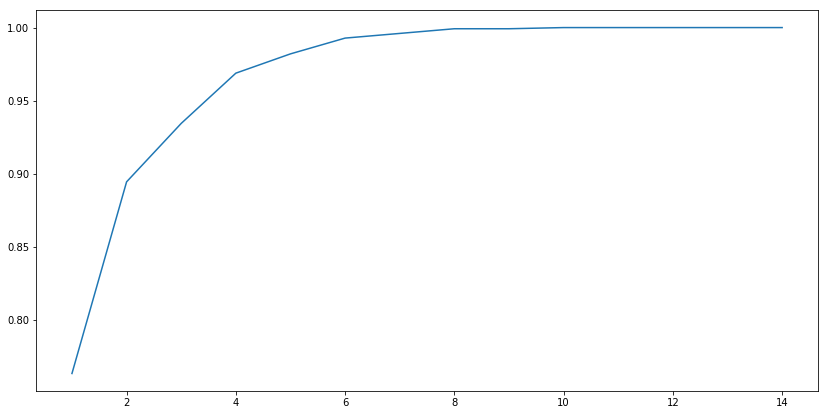

In [31]:
plt.figure(figsize=(14,7))
plt.plot(data[:,0],data[:,1])
# plt.ylim(0,1)
plt.show()

# Attempt to find incorrect labels in the training set

In [18]:
dftrain = []
for i in tqdm(range(len(trainset))):
    instance, label = trainset[i]
    instance = normalise(instance)
    instance_cuda = torch.from_numpy(instance.reshape(1,1,base_sampling_rate*n_seconds))[:,:,::downsampling]
    with torch.no_grad():
        pred = model(instance_cuda)[0][0].cpu().numpy()
    dftrain.append({
        'i': i,
        'name': trainset.datasetid_to_name[i],
        'sex': label_to_sex[label],
        'rms': np.sqrt(np.square(instance)).mean(),
        'rmedians': np.median(np.sqrt(np.square(instance))),
        'rsums': np.sum(np.sqrt(np.square(instance))),
        'mean': np.mean(instance),
        'pred':pred,
        'label': label
    })
dftrain = pd.DataFrame(dftrain)

In [19]:
dftrain = dftrain.assign(
    error=abs(dftrain['pred'].astype(float)-dftrain['label'].astype(int)),
    label=dftrain['label'].astype(int),
    correct=(dftrain['pred'] > 0.5) == dftrain['label'],
    pred=dftrain['pred'].astype(float)
)

In [20]:
dftrain.groupby('correct').agg({'i': 'count'})

,i
correct,
False,2538
True,127114


In [25]:
dftrain.groupby('sex').agg({'i': 'count'})

,i
sex,
F,62562
M,67090


The training data contains a slight bias towards samples of male speakers as 51.7% of samples are male.

In [27]:
df.groupby('sex').agg({'i': 'count'})

,i
sex,
F,1280
M,1023


Interestingly the validation set contains the reverse bias.

In [22]:
gb = dftrain.groupby('name').agg({'error': ['mean','max'], 'pred': 'mean', 'label': 'mean'})
gb.columns = ['.'.join(col).strip() for col in gb.columns.values]
gb['label.gender'] = gb['label.mean'].apply(lambda l: label_to_sex[int(l)])
gb.sort_values('error.mean',ascending=False).head(50)

,pred.mean,label.mean,error.mean,error.max,label.gender
name,,,,,
Cate Barratt,0.447470,1,0.552530,0.999506,F
Karen Howard,0.494806,1,0.505194,0.997845,F
librarianite,0.496577,1,0.503423,0.992171,F
Rowdy Delaney,0.498148,0,0.498148,0.992174,M
Jeannie,0.541430,1,0.458570,0.990712,F
DVoice,0.548389,1,0.451611,0.999850,F
Elisabeth Shields,0.568857,1,0.431143,0.998948,F
Kathy Wright,0.588723,1,0.411277,0.996335,F
Mary Herndon Bell,0.595757,1,0.404243,0.999969,F


Notably the `Art Leung` speaker sometimes imitates a female voice in his reading.

In [23]:
label_to_sex

{False: 'M', True: 'F'}

In [24]:
dftrain[dftrain['name']=='Deborah Knight'][['name','i','pred','label','error','correct','sex']].sort_values('error')

,name,i,pred,label,error,correct,sex
23838,Deborah Knight,23838,0.999763,1,0.000237,True,F
23781,Deborah Knight,23781,0.999752,1,0.000248,True,F
23777,Deborah Knight,23777,0.999716,1,0.000284,True,F
23856,Deborah Knight,23856,0.999396,1,0.000604,True,F
23865,Deborah Knight,23865,0.999329,1,0.000671,True,F
23863,Deborah Knight,23863,0.999063,1,0.000937,True,F
23761,Deborah Knight,23761,0.998753,1,0.001247,True,F
23857,Deborah Knight,23857,0.998220,1,0.001780,True,F
23829,Deborah Knight,23829,0.997979,1,0.002021,True,F
23867,Deborah Knight,23867,0.997746,1,0.002254,True,F


# Run this model against a sample of my own voice

In [39]:
import soundfile as sf

In [50]:
voice, sampling_rate = sf.read('/home/oscar/Downloads/oscar.flac')
# voice, sampling_rate = sf.read('/home/oscar/Downloads/harry.flac')

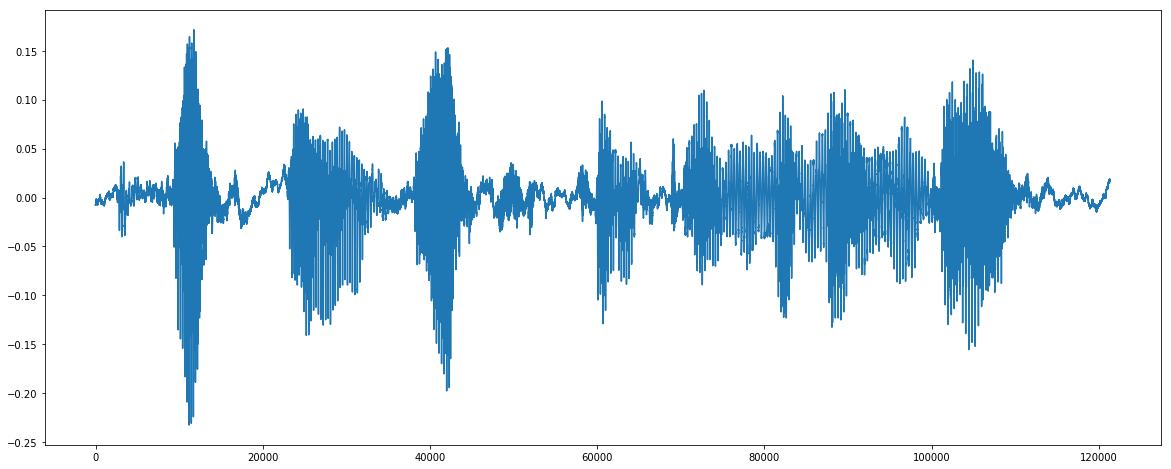

In [51]:
plt.figure(figsize=(20,8))
plt.plot(voice.sum(axis=1))
plt.show()

In [52]:
voice.shape[0]/sampling_rate

2.75156462585034

In [53]:
mono_voice = voice.sum(axis=1)

In [54]:
from scipy.signal import resample

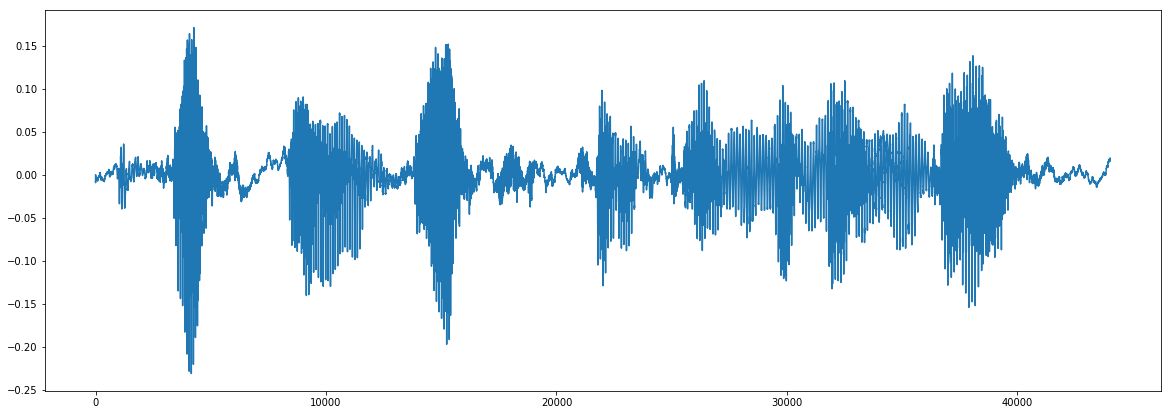

In [55]:
plt.figure(figsize=(20,7))
plt.plot(resample(mono_voice, int(mono_voice.shape[0]*base_sampling_rate/sampling_rate)))
plt.show()

In [56]:
instance_cuda.shape

torch.Size([1, 1, 12000])

In [57]:
downsampled_mono_voice = resample(mono_voice, int(mono_voice.shape[0]*base_sampling_rate/sampling_rate))

In [58]:
model(
    torch.from_numpy(normalise(downsampled_mono_voice)).cuda().reshape((1, 1, -1))
).item()

0.9005135403359698

In [59]:
model(
    torch.from_numpy(downsampled_mono_voice).cuda().reshape((1, 1, -1))
).item()

0.902302952702945

In [60]:
label_to_sex

{False: 'M', True: 'F'}

# Notes